In [5]:
!pip install tensorflow
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
import os
import math
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import roc_curve

from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, LSTM, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

# Importation des données

In [2]:
# installation du package kaggle
!pip install kaggle

In [8]:
# télécharger les données depuis kaggle
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0




  0%|          | 0.00/149M [00:00<?, ?B/s]
  1%|          | 1.00M/149M [00:00<01:29, 1.73MB/s]
  1%|1         | 2.00M/149M [00:00<00:47, 3.26MB/s]
  2%|2         | 3.00M/149M [00:00<00:32, 4.63MB/s]
  3%|3         | 5.00M/149M [00:01<00:21, 7.15MB/s]
  5%|4         | 7.00M/149M [00:01<00:16, 8.97MB/s]
  6%|6         | 9.00M/149M [00:01<00:14, 10.0MB/s]
  7%|7         | 11.0M/149M [00:01<00:13, 10.4MB/s]
  9%|8         | 13.0M/149M [00:01<00:13, 10.6MB/s]
 10%|#         | 15.0M/149M [00:01<00:13, 10.6MB/s]
 11%|#1        | 17.0M/149M [00:02<00:12, 10.9MB/s]
 13%|#2        | 19.0M/149M [00:02<00:11, 11.4MB/s]
 14%|#4        | 21.0M/149M [00:02<00:11, 11.2MB/s]
 15%|#5        | 23.0M/149M [00:02<00:11, 11.4MB/s]
 17%|#6        | 25.0M/149M [00:03<00:19, 6.54MB/s]
 18%|#8        | 27.0M/149M [00:03<00:18, 6.90MB/s]
 19%|#8        | 28.0M/149M [00:03<00:19, 6.49MB/s]
 20%|#9        | 29.0M/149M [00:03<00:20, 6.17MB/s]
 20%|##        | 30.0M/149M [00:04<00:18, 6.57MB/s]
 21%|##        | 31.

In [3]:
# Définir les chemins d'accès
BASE_PATH = "./brain_tumor_data/"
train_path = os.path.join(BASE_PATH, "Training")
test_path = os.path.join(BASE_PATH, "Testing")


In [4]:
# différentes classes disponibles
classes = sorted(os.listdir(train_path))
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
# fonction de conversion en dataframe

def to_frame(path):
  """
  Cette fonction prend un chemin de répertoire comme entrée et crée un DataFrame
  Pandascontenant deux colonnes: 'class path' avec le chemin pour
  accéder aux différents éléments de la classe et 'Class' le nom des classes
  correspondantes.

  Args:
      path (str): Le chemin d'accès au répertoire contenant les sous-répertoires de classe
                  et les fichiers d'image.

  Returns:
      pd.DataFrame: Un DataFrame avec les colonnes 'class path'
      (chemins complets vers les images) et 'Class' (noms de classe extraits
      des noms de sous-répertoire).
  """

  class_types = []  # Liste pour stocker les noms des classes extraits
  class_paths = []  # Liste pour stocker les chemins complets des images

  # Obtenir la liste des noms de sous-répertoires dans le répertoire donné
  files = os.listdir(path)

  for file in files:
    # Construire le chemin complet vers le sous-répertoire (classe d'image)
    label_dir = os.path.join(path, file)

    # Obtenir la liste des noms de fichiers dans le sous-répertoire actuel (images)
    label = os.listdir(label_dir)

    for image in label:
      # Construire le chemin complet vers le fichier d'image
      image_path = os.path.join(label_dir, image)

      # Extraire le nom de classe du nom du sous-répertoire (label ou classe)
      class_name = os.path.splitext(file)[0]

      # Ajouter le chemin de l'image et le nom de la classe aux listes respectives
      class_paths.append(image_path)
      class_types.append(class_name)

  # Créer des séries Pandas à partir des listes (une série pour chaque colonne)
  image_classes = pd.Series(class_types, name='class')
  image_paths = pd.Series(class_paths, name='class path')

  # Concaténer les séries dans un DataFrame avec l'ordre des colonnes spécifié
  df = pd.concat([image_paths, image_classes], axis=1)

  return df

In [6]:
# conversion des données de train et des données de test en dataframe
train_df = to_frame(train_path)
test_df = to_frame(test_path)

In [7]:
train_df.head(2)

,class path,class
0,./brain_tumor_data/Training\glioma\Tr-glTr_000...,glioma
1,./brain_tumor_data/Training\glioma\Tr-glTr_000...,glioma


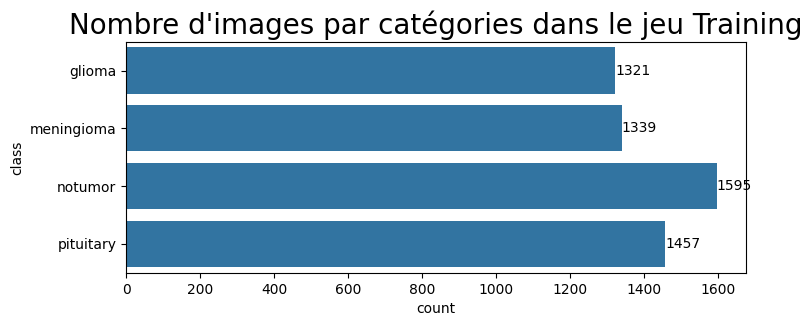

In [21]:
# Répartition des classes dans le jeu Training
plt.figure(figsize=(8,3))
ax = sns.countplot(data=train_df , y=train_df['class'])
plt.title("Nombre d'images par catégories dans le jeu Training", fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

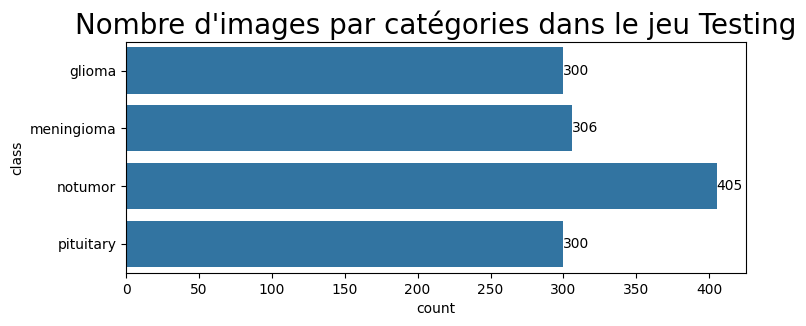

In [22]:
# Répartition des classes dans le jeu Testing
plt.figure(figsize=(8,3))
ax = sns.countplot(data=test_df , y=test_df['class'])
plt.title("Nombre d'images par catégories dans le jeu Testing", fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [23]:
# définir une fonction pour l'affichage des images

def display_random_images(df, num_images=5):
  """
  Cette fonction affiche un certain nombre d'images aléatoires à partir d'un
  DataFrame Pandas.

  Args:
      df (pd.DataFrame): Le DataFrame contenant les chemins des images et les noms de classes
                          dans les colonnes 'Chemin de la classe' et 'Classe' respectivement.
      num_images (int, optional): Le nombre d'images aléatoires à afficher (par défaut 5).
  """

  # Sélectionner des indices aléatoires dans le DataFrame
  random_indices = random.sample(range(len(df)), num_images)

  # Créer une figure et des axes pour l'affichage des images
  fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

  for i, idx in enumerate(random_indices):
    # Obtenir le chemin de l'image et le nom de la classe de la ligne sélectionnée
    image_path = df.loc[idx, 'class path']
    class_name = df.loc[idx, 'class']

    # Lire l'image en utilisant OpenCV
    image = cv2.imread(image_path)

    # Convertir l'image de BGR vers RGB pour l'affichage correct par matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Afficher l'image sur l'axe correspondant
    axes[i].imshow(image)

    # Définir le titre de l'axe avec le nom de la classe
    axes[i].set_title(f'Class: {class_name}')

    # Désactiver les axes pour une présentation plus propre
    axes[i].axis('off')

  # Afficher la figure avec les images aléatoires
  plt.show()

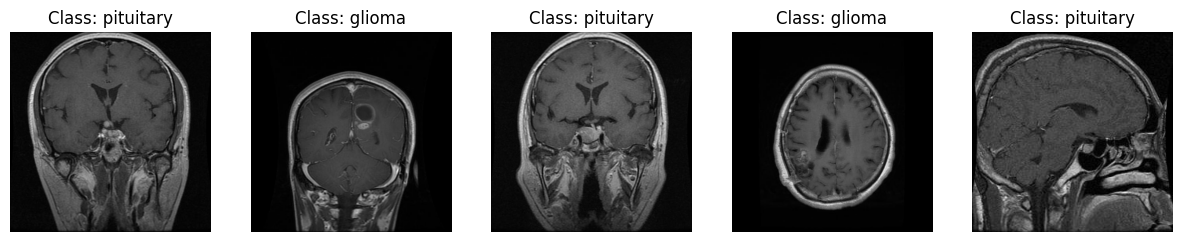

In [24]:
# affichons quelques images du jeu Training
display_random_images(train_df)

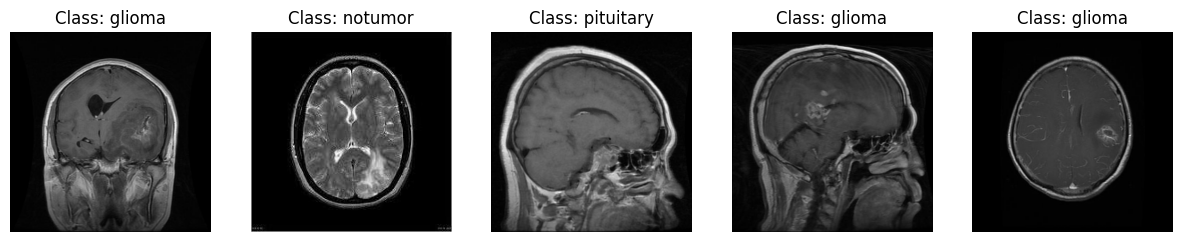

In [25]:
# affichons quelques images du jeu Testing
display_random_images(test_df)

## Resizing ou croping

Convertit chaque image en nuances de gris.
Applique des techniques de traitement d'image pour extraire la zone d'intérêt.
Recadre l'image autour de cette zone et redimensionne à une taille uniforme (img_size).
Résultat : Une liste d'images recadrées et redimensionnées.

In [29]:
# définition de la fonction pour resize l'image

import imutils

def resize_imgs(img_paths, img_size=150):
  """
  Cette fonction a pour but de recadrer une liste d'images en se basant sur
  leurs points extrêmes et leur donner une même dimension

  Args:
      img_paths (list[str]): Une liste de chemins d'accès aux images.
      img_size : Taille finale à donner aux images.

  Returns:
      list[np.ndarray]: Une liste d'images recadrées ne contenant que les zones d'intérêt.
  """

  cropped_imgs = []  # Liste pour stocker les images recadrées

  for path in img_paths:
    # Charger l'image depuis le chemin d'accès
    img = cv2.imread(path)

    # Convertir en nuances de gris pour la détection des contours
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Appliquer un flou gaussien pour réduire le bruit
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Seuillage de l'image pour séparer l'objet d'intérêt du fond
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Érosion et dilatation pour supprimer les petits éléments de bruit
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Trouver les contours dans l'image binaire et récupérer le plus grand
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Trouver les points extrêmes (gauche, droite, haut, bas)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Marge de pixels à ajouter autour de la zone d'intérêt (ajustement optionnel)
    ADD_PIXELS = 0

    # Découper l'image en utilisant les points extrêmes et la marge
    new_img_1 = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                 extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    # Définir une taille uniforme pour toutes les images
    new_img = cv2.resize(new_img_1, (img_size, img_size))

    # Ajouter l'image recadré à la liste
    cropped_imgs.append(new_img)

  return cropped_imgs

In [32]:
# Application de la fonction au jeu Training

paths = train_df['class path'].tolist()
labels = train_df['class'].tolist()

cropped_images = resize_imgs(paths, img_size=150)

# Créer un nouveau répertoire pour stocker les images recadrées
import shutil

output_dir = './clean_data'
# Vérifie si le répertoire existe
if os.path.exists(output_dir):
  # Supprime le répertoire existant
  shutil.rmtree(output_dir)

# Crée un nouveau répertoire
os.makedirs(output_dir)

# Liste pour stocker les nouveaux chemins d'accès et les labels
new_img_paths = []

# Sauvegarder les images recadrées et créer les nouveaux chemins d'accès
for i, (img, label) in enumerate(zip(cropped_images, labels)):
    new_img_name = f"cropped_image_{i}_{label}.jpg"
    new_img_path = os.path.join(output_dir, new_img_name)
    cv2.imwrite(new_img_path, img)
    new_img_paths.append(new_img_path)

# Créer un nouveau DataFrame avec les chemins d'accès et les labels
clean_train = pd.DataFrame({'class path': new_img_paths, 'class': labels})

# Afficher le DataFrame
clean_train.head(2)

,class path,class
0,./clean_data\cropped_image_0_glioma.jpg,glioma
1,./clean_data\cropped_image_1_glioma.jpg,glioma


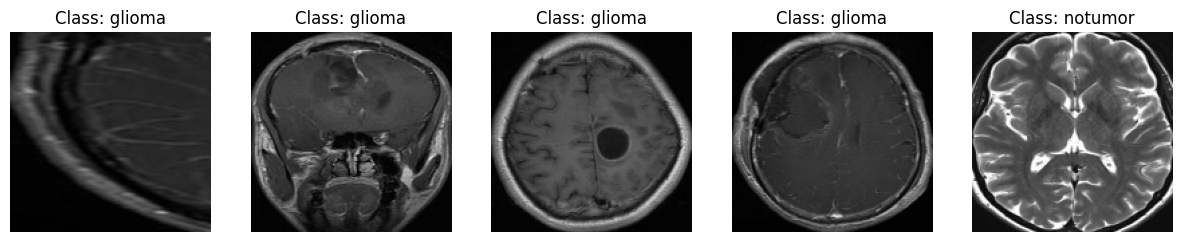

In [33]:
# Visualisation des données nétoyées
display_random_images(clean_train)

## Normalisation

In [34]:
# fonction de normalisation

def normalize_img(image_list):
    """
    Cette fonction prend en entrée une liste de tableaux NumPy représentant des
    images et retourne une liste d'images normalisées. Chaque pixel de chaque
    image est mis à l'échelle entre 0 et 1 en divisant sa valeur par 255.

    Args:
        liste_images (list): Liste de tableaux NumPy représentant des images.

    Returns:
        list: Liste d'images normalisées.
    """

    # Normaliser les images en les mettant à l'échelle entre 0 et 1
    normalized_images = [image.astype('float32') / 255.0 for image in image_list]

    return normalized_images

## Data augmentation

Le data augmentation (ou augmentation de données) est une technique utilisée en intelligence artificielle (IA) pour augmenter la quantité de données disponibles pour l'entraînement de modèles de machine learning. Elle consiste à appliquer des transformations à des données existantes pour générer de nouvelles données, ce qui permet d'améliorer la robustesse et la précision des modèles en réduisant les problèmes liés à la quantité et à la qualité des données initiales.

Par ailleurs, l'augmentation des données est l'une des approches les plus essentielles pour résoudre les problèmes de distribution déséquilibrée des données. De nombreuses recherches sur la classification des tumeurs cérébrales ont utilisé cette méthode, qui incorpore des opérations de transformation géométrique telles que la rotation, le zoom, et la luminosité.

Nous allons donc écrire une fonction qui génère des images pour obtenir au final un jeu d'entraînement avec des classes équilibrées.

In [35]:
# fonction de data augmentation

def augment_img(images, labels, target_count=2000, img_size=(150, 150)):
    """
    Cette fonction réalise la data augmentation pour générer un total de target_count images par label
    à partir de listes contenant les images et les labels.

    Args:
        images (list): Liste d'images au format numpy array.
        labels (list): Liste des labels correspondant aux images.
        target_count (int): Nombre d'images souhaitées par label après augmentation.
        img_size (tuple): Taille des images (hauteur, largeur).

    Returns:
        list: Liste d'images augmentées sous forme de tableaux NumPy.
        list: Liste des labels correspondant aux images augmentées.
    """

    # Créer l'ImageDataGenerator pour la data augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0, 0.7]
    )

    augmented_images = []
    augmented_labels = []

    # Créer un DataFrame à partir des listes pour faciliter le traitement
    df = pd.DataFrame({'image': images, 'label': labels})

    # Parcourir chaque label unique
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        label_count = len(label_df)

        if label_count == 0:
            continue

        # Calculer le nombre d'images supplémentaires à générer
        num_additional_images = target_count - label_count

        # Calculer le nombre d'images à générer par image
        n_add_img_per_img = num_additional_images/label_count

        j = 0
        for _, row in label_df.iterrows():
            j += 1
            img = row['image']

            img = cv2.resize(img, img_size)  # Redimensionner l'image
            img = img.reshape((1,) + img.shape)  # Redimensionner pour le générateur

            # Ajouter l'image originale normalisée à la liste
            augmented_images.append(img[0]/255)
            augmented_labels.append(label)

            # Générer les images augmentées si nécessaire
            if n_add_img_per_img > 0:
                i = 0
                for batch in datagen.flow(img, batch_size=1):
                    i += 1
                    # Vérifier si le nombre d'images générées est supérieur à num_additional_images
                    if j*i + 1 >= num_additional_images:
                        break
                    else:
                        augmented_images.append(batch[0])
                        augmented_labels.append(label)

                    if i >= n_add_img_per_img:
                        break

    return augmented_images, augmented_labels

In [36]:
# Application de la fonction au jeu Training néttoyé

# Appeler la fonction pour générer les images augmentées
augmented_img, augmented_labels = augment_img(cropped_images, clean_train["class"], target_count=1600, img_size=(150, 150))


In [37]:
# Créer un nouveau répertoire pour stocker les images augmentées
augment_dir = '/augmented_data'
# Vérifie si le répertoire existe
if os.path.exists(augment_dir):
  # Supprime le répertoire existant
  shutil.rmtree(augment_dir)

# Crée un nouveau répertoire
os.makedirs(augment_dir)

# Liste pour stocker les nouveaux chemins d'accès
augmented_img_paths = []

# Sauvegarder les images augmentées et créer les nouveaux chemins d'accès
for i, (img, label) in enumerate(zip(augmented_img, augmented_labels)):
    new_img_name = f"augmented_image_{i}_{label}.jpg"
    new_img_path = os.path.join(output_dir, new_img_name)
    cv2.imwrite(new_img_path, img * 255)  # Multiplier par 255 pour convertir en image
    augmented_img_paths.append(new_img_path)

# Créer un DataFrame avec les chemins d'accès et les labels des images augmentées
clean_train_aug = pd.DataFrame({'class path': augmented_img_paths, 'class': augmented_labels})

# Afficher la DataFrame augmentée
clean_train_aug.head(2)

,class path,class
0,./clean_data\augmented_image_0_glioma.jpg,glioma
1,./clean_data\augmented_image_1_glioma.jpg,glioma


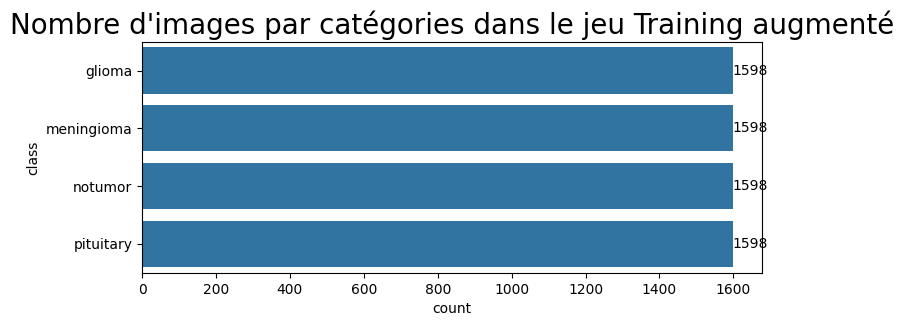

In [38]:
# Répartition des classes dans le nouveau jeu augmenté
plt.figure(figsize=(8,3))
ax = sns.countplot(data=clean_train_aug , y=clean_train_aug['class'])
plt.title("Nombre d'images par catégories dans le jeu Training augmenté", fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

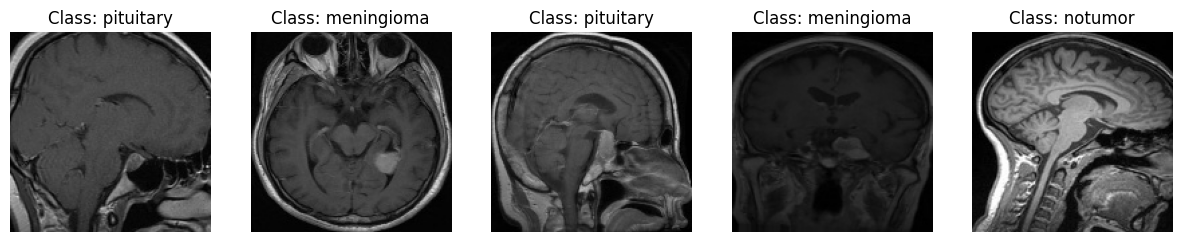

In [39]:
# Visualisation du nouveau jeu de Training
display_random_images(clean_train_aug)

## Labelisation

Nous allons à present transformer nos différentes classes en chiffres.

- 'notumor' = 0

- 'glioma' = 1

- 'meningioma' = 2

- 'pituitary' = 3

In [40]:
clean_train_aug["label"] = clean_train_aug["class"].map({"notumor": 0, "glioma": 1, "meningioma": 2, "pituitary": 3})

In [41]:
clean_train_aug.head(2)

,class path,class,label
0,./clean_data\augmented_image_0_glioma.jpg,glioma,1
1,./clean_data\augmented_image_1_glioma.jpg,glioma,1


# Modélisation

Commençons par séparer nos données en jeu d'entrainement et jeu de validation


In [42]:
# création d'un dataframe avec les images et leurs labels
# Créez un DataFrame à partir de ces listes
df_train_img = pd.DataFrame({'image': augmented_img, 'label': clean_train_aug["label"]})

# Affichez le DataFrame
df_train_img.head(2)

,image,label
0,"[[[0.00784313725490196, 0.00784313725490196, 0...",1
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1


In [43]:
# division en training et validation
final_train, valid_df = train_test_split(df_train_img, train_size=0.7,
                                         random_state=20, stratify=df_train_img['label'])

In [44]:
# Création de X_train, Y_train X_valid, Y_valid
x_train = final_train["image"].to_list() # liste des images
y_train = final_train["label"].to_list() # liste des labels
x_valid = valid_df["image"].to_list() # liste des images
y_valid = valid_df["label"].to_list() # liste des labels

In [45]:
# Convertir les listes de tableaux NumPy en tenseurs TensorFlow
x_train_tensor = tf.convert_to_tensor(x_train)
x_valid_tensor = tf.convert_to_tensor(x_valid)


In [46]:
# tranformer la variable label en dummy variables
y_train_tensor = tf.one_hot(y_train, depth=4)
y_valid_tensor = tf.one_hot(y_valid, depth=4)

## Implémentation du modèle

### Xception modifié

Dans cette partie , nous utilisons le réseau neuronal convolutif (CNN) qui est une architecture réseau pour le Deep Learning.\
Il peut comporter de nombreuses couches, parfois des dizaines voire des centaines, chacune apprenant à reconnaître différentes caractéristiques visuelles d'une image. À chaque étape, des filtres sont appliqués à l'image initiale avec différentes résolutions, et la sortie de chaque filtre est utilisée comme entrée pour la couche suivante. Au départ, ces filtres peuvent être simples, capturant des traits basiques tels que la luminosité et les contours, puis ils se complexifient progressivement pour identifier des caractéristiques spécifiques à l'objet, de plus en plus sophistiquées. Il comporte principalement  les  couches
- La couche de convolution pour extraire des caractéristiques importantes des images
- La couche de pooling pour réduire la dimensionnalité
- La couche ReLU (Rectified linear unit)

Conv2D :
Extraire des motifs ou caractéristiques spécifiques des images.
MaxPooling2D :
Réduire les dimensions tout en conservant les informations clés.
Flatten :
Convertir les cartes de caractéristiques en une seule liste pour les couches Fully Connected.
Dense :
Apprendre des relations complexes entre les caractéristiques extraites et effectuer la classification.
Dropout :
Prévenir le surapprentissage et améliorer la généralisation.

In [47]:
# Définition de la taille des images en entrée du modèle
img_shape = (150, 150, 3)

# Chargement du modèle Xception pré-entraîné sans la couche fully connected
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape)

# Création du modèle séquentiel
model_cnn = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),

    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compilation du modèle avec l'optimiseur Adamax, la perte entropie croisée catégorique et les métriques de performance
model_cnn.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Affichage d'un résumé du modèle
model_cnn.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 51s 1us/step   


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 32)            │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,540,092 (82.17 MB)

 Trainable params: 21,485,564 (81.96 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [51]:
# résumé du modèle
!pip install pydot
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [52]:
hist = model_cnn.fit(x=x_train_tensor,
                     y=y_train_tensor,
                     epochs=5,
                     validation_data=(x_valid_tensor, y_valid_tensor),
                     shuffle=True)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1179s 8s/step - accuracy: 0.4659 - loss: 1.0808 - precision: 0.9125 - recall: 0.2391 - val_accuracy: 0.4802 - val_loss: 4.9366 - val_precision: 0.5046 - val_recall: 0.4614
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 751s 5s/step - accuracy: 0.7947 - loss: 0.5459 - precision: 0.9168 - recall: 0.5885 - val_accuracy: 0.9239 - val_loss: 0.3108 - val_precision: 0.9280 - val_recall: 0.9202
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 724s 5s/step - accuracy: 0.9353 - loss: 0.1801 - precision: 0.9480 - recall: 0.9267 - val_accuracy: 0.9353 - val_loss: 0.2942 - val_precision: 0.9433 - val_recall: 0.9286
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 700s 5s/step - accuracy: 0.9653 - loss: 0.1086 - precision: 0.9695 - recall: 0.9591 - val_accuracy: 0.9406 - val_loss: 0.2340 - val_precision: 0.9486 - val_recall: 0.9333
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 691s 5s/step - accuracy: 0.9783 - loss: 0.0694 - precision: 0.9844 - recall: 0.9739 - val_accuracy: 0.9661 - val_loss: 0

#### Courbes d'apprentissages

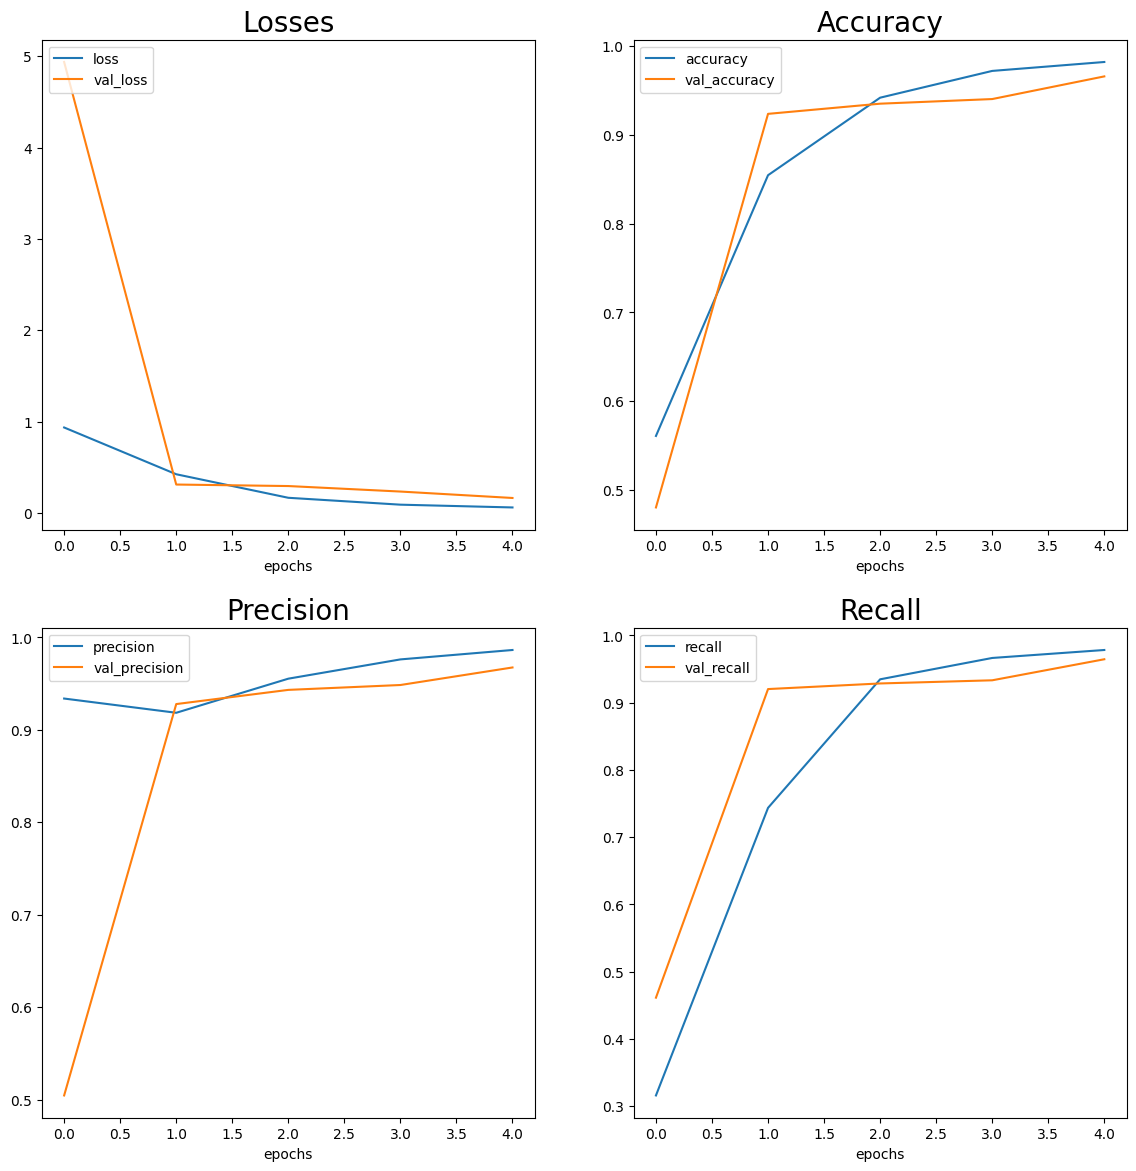

In [53]:
# affichage des courbes d'apprentissage
plt.figure(figsize=(14, 14))

# courbe d'évolution des pertes
plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# courbe d'évolution de l'accuracy
plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# courbe d'évolution de la précision
plt.subplot(2, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# courbe d'évolution du recall
plt.subplot(2, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

In [ ]:
model_cnn.save("model.h5")
print("Modèle sauvegardé avec succès!")
